## IMPORTING THE DATASET

In [ ]:
import os
from pathlib import Path

base = Path('/kaggle/input')

for p in base.iterdir():
    print(p)

DATASET_DIR = Path('/kaggle/input/waste-classification-images/dataset') 

print("Dataset directory exists:", DATASET_DIR.exists())

In [ ]:
for sub in DATASET_DIR.iterdir():
    if sub.is_dir():
        print(sub.name, "->", len(list(sub.glob('*.*'))), "images")

##  DATA PREPROCESSING AND SPLITTING

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2, 
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


In [ ]:
class_names = train_ds.class_names
print("Class names:", class_names)
print("Training batches:", len(train_ds))
print("Validation batches:", len(val_ds))

### visualizing some images


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
#for gpu caching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### BUILDING THE MODEL

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(class_names)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
], name='data_augmentation')

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  

# full model
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)                  
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) 
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
#Callbacks (save best model, early stop)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_waste_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [checkpoint, earlystop, reduce_lr]


### Training - epochs

In [34]:
EPOCHS = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6544 - loss: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.87214, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6560 - loss: 0.8494 - val_accuracy: 0.8721 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 2/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8684 - loss: 0.3553
Epoch 2: val_accuracy improved from 0.87214 to 0.87595, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8685 - loss: 0.3551 - val_accuracy: 0.8760 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 3/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8792 - loss: 0.3281
Epoch 3: val_accuracy improved from 0.87595 to 0.90076, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8791 - loss: 0.3281 - val_accuracy: 0.9008 - val_loss: 0.2649 - learning_rate: 0.0010
Epoch 4/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8792 - loss: 0.2855
Epoch 4: val_accuracy did not improve from 0.90076
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8793 - loss: 0.2854 - val_accuracy: 0.9008 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 5/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9117 - loss: 0.2376
Epoch 5: val_accuracy improved from 0.90076 to 0.91794, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9116 - loss: 0.2376 - val_accuracy: 0.9179 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 6/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9079 - loss: 0.2599
Epoch 6: val_accuracy did not improve from 0.91794
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9079 - loss: 0.2597 - val_accuracy: 0.9046 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 7/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9240 - loss: 0.2072
Epoch 7: val_accuracy did not improve from 0.91794
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9240 - loss: 0.2073 - val_accuracy: 0.8836 - val_loss: 0.2933 - learning_rate: 0.0010
Epoch 8/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9213 - loss: 0.2020
Epoch 8: val_accuracy improved from 0.91794 to 0.91985, saving model to /kaggle/working/best_waste_model.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9212 - loss: 0.2021 - val_accuracy: 0.9198 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 9/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9456 - loss: 0.1579
Epoch 9: val_accuracy did not improve from 0.91985
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9455 - loss: 0.1579 - val_accuracy: 0.9160 - val_loss: 0.2127 - learning_rate: 5.0000e-04
Epoch 10/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9540 - loss: 0.1318
Epoch 10: val_accuracy improved from 0.91985 to 0.92176, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9540 - loss: 0.1319 - val_accuracy: 0.9218 - val_loss: 0.2111 - learning_rate: 5.0000e-04
Epoch 11/12
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9449 - loss: 0.1550
Epoch 11: val_accuracy improved from 0.92176 to 0.92748, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9448 - loss: 0.1549 - val_accuracy: 0.9275 - val_loss: 0.2019 - learning_rate: 5.0000e-04
Epoch 12/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1500
Epoch 12: val_accuracy did not improve from 0.92748
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9506 - loss: 0.1500 - val_accuracy: 0.9103 - val_loss: 0.2224 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 11.


## fine tuning

In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Optionally freeze lower layers to keep low-level features intact:
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 8
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

In [35]:
loss, acc = model.evaluate(val_ds)
print("Validation loss:", loss, "Validation accuracy:", acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9388 - loss: 0.1725
Validation loss: 0.2018989473581314 Validation accuracy: 0.927480936050415


In [37]:
# save as HDF5
model.save('/kaggle/working/waste_classifier.h5')

## Class-wise metrics & confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
                 precision    recall  f1-score   support

      1-Plastic     0.9602    0.8711    0.9135       194
        2-Paper     0.9167    0.9670    0.9412        91
        3-Metal     0.8837    0.9383    0.9102       162
4-Food Organics     0.9625    1.0000    0.9809        77

       accuracy                         0.9275       524
      macro avg     0.9308    0.9441    0.9364       524
   weighted avg     0.9293    0.9275    0.9272       524



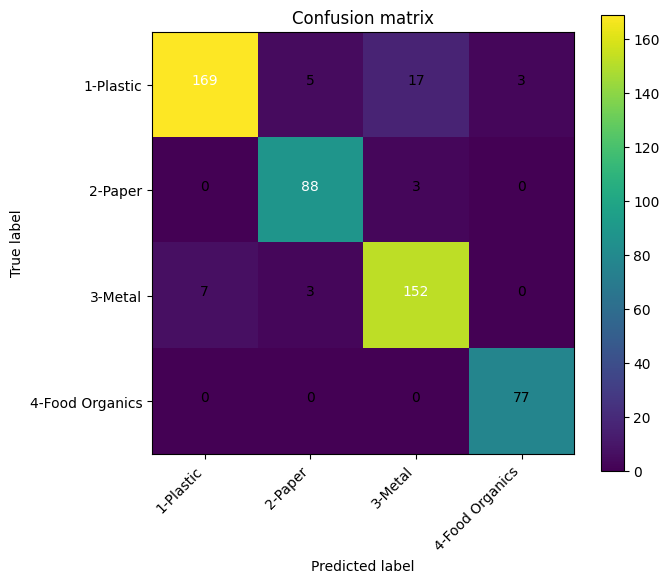

In [40]:
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import itertools

y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
y_true = y_true.flatten()
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# classification report
print(skm.classification_report(y_true, y_pred, target_names=class_names, digits=4))

# confusion matrix
cm = skm.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### predicting with sample data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    predicted_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(5): 
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()